# Velas class

The Velas class provides a basic interface to interact with the OCHLV candlesticks from Technical Analysis data. An object of this class contains the candlestick data for a given symbol and timeframe. It also implements a set of functionalities to operate with the candlesticks:
<ul>   
    <li> Loading and saving the raw candlestick data from different sources (.csv, SQL..).</li>
    <li> Handling the data updating, missing data, separating trading sessions...</li>
    <li> Technical Analysis indicators: returns, MAs, oscillators...</li>
    <li> Common plots.</li>
</ul>    

### Import libraries

For running the code in this notebook, we need to execute the following imports:
- We import the needed standard libraries first (datetime, pandas...).
- Then we add the path of the directory above (main traphing folder) to the system path. This is done so that when import the traphing library, it will load the local version in the folder, instead of the version installed with pip. 
- Finally we load the traphing classes, functions and enums from the library.

In [1]:
import datetime as dt
import pandas as pd
#import matplotlib.pyplot as plt
from IPython.display import Image,HTML,Video
%matplotlib qt

In [2]:
import sys
sys.path.insert(0,"..") # Adds higher directory to python modules path.

In [3]:
from traphing.data_classes import Velas
from traphing.utils import Timeframes, unwrap, MarketHours
from traphing.graph.Gl import gl

## Creating a Velas instance
When we create a Velas object, we need to specify the basic parameters of the candlestick data:
 - <b>symbol_name</b>: The name of the symbol given by the broker we are using (it can be different from broker to broker).
 -  <b>timeframe</b>: The timeframe of the candlesticks, i.e. M5, M15, D1... (using an Enum).

No candlestick data is loaded when creating the object but an empty *pandas DataFrame* is created.

In [4]:
symbol_name = "AUDCHF"
timeframe = Timeframes.M15

velas = Velas(symbol_name, timeframe)
print (type(velas))

<class 'traphing.data_classes._Velas._Velas.Velas'>


In [5]:
velas.df

Empty DataFrame
Columns: [Open, High, Low, Close, Volume]
Index: []

## Loading candlestick data

The candlestick data can be provided from different sources:
 - A *pandas DataFrame*.
 - A set of .csv files.
 - SQL database.
 
No matter what the source of the data is, the candlesticks are stored within the *Velas* object as rows in a *pandas DataFrame*, which has the timestamp of the candlesticks as index.

### From .csv

The .csv files that are loaded/saved using the *Velas* in-built functions follow the following naming convention:
Given a root folder *storage_folder*, for a given *symbol_name* and *timeframe*, the filepath of the .csv file is:
- {storage_folder}/{timeframe}/{symbol_name}_{timeframe}.csv

The following code calls the function to load the candlesticks. Notice how we only need to specify the *storage_folder* since the *Velas* object already has the rest of the information.

In [6]:
storage_folder = "../tests/data/storage/"
velas.load_data_from_csv(storage_folder)

Size ../tests/data/storage/M15/AUDCHF_M15.csv:  100400  rows


## Pandas DataFrame data
Once the candlestick data has been loaded, we can access the basic information through the attributes:
- df: The *pandas DataFrame*.
- timestamps: The index of the pandas *DataFrame*.
- dates: The dates of the *DataFrame*'s index.

In [7]:
velas.df

Open     High      Low    Close  Volume
Timestamp                                                      
2015-08-14 23:45:00  0.71976  0.72021  0.71930  0.71937   592.0
2015-08-17 00:00:00  0.71934  0.72001  0.71934  0.71991    56.0
2015-08-17 00:15:00  0.71992  0.72003  0.71867  0.71999   181.0
2015-08-17 00:30:00  0.71999  0.72034  0.71966  0.71983   124.0
2015-08-17 00:45:00  0.71985  0.72025  0.71975  0.71978    81.0
...                      ...      ...      ...      ...     ...
2019-08-30 19:45:00  0.66637  0.66637  0.66599  0.66606   521.0
2019-08-30 20:00:00  0.66606  0.66615  0.66581  0.66592   825.0
2019-08-30 20:15:00  0.66591  0.66628  0.66579  0.66597   961.0
2019-08-30 20:30:00  0.66597  0.66628  0.66574  0.66606  1118.0
2019-08-30 20:45:00  0.66606  0.66626  0.66593  0.66601   852.0

[100400 rows x 5 columns]

In [8]:
velas.timestamps

DatetimeIndex(['2015-08-14 23:45:00', '2015-08-17 00:00:00',
               '2015-08-17 00:15:00', '2015-08-17 00:30:00',
               '2015-08-17 00:45:00', '2015-08-17 01:00:00',
               '2015-08-17 01:15:00', '2015-08-17 01:30:00',
               '2015-08-17 01:45:00', '2015-08-17 02:00:00',
               ...
               '2019-08-30 18:30:00', '2019-08-30 18:45:00',
               '2019-08-30 19:00:00', '2019-08-30 19:15:00',
               '2019-08-30 19:30:00', '2019-08-30 19:45:00',
               '2019-08-30 20:00:00', '2019-08-30 20:15:00',
               '2019-08-30 20:30:00', '2019-08-30 20:45:00'],
              dtype='datetime64[ns]', name='Timestamp', length=100400, freq=None)

In [9]:
velas.dates

Index([2015-08-14, 2015-08-17, 2015-08-17, 2015-08-17, 2015-08-17, 2015-08-17,
       2015-08-17, 2015-08-17, 2015-08-17, 2015-08-17,
       ...
       2019-08-30, 2019-08-30, 2019-08-30, 2019-08-30, 2019-08-30, 2019-08-30,
       2019-08-30, 2019-08-30, 2019-08-30, 2019-08-30],
      dtype='object', name='Timestamp', length=100400)

### Specifying a time interval

When we load the candlestick data, any operation performed over the *Velas* object (fetching data, computing indicator...) will be applied to all of its samples (rows in the *DataFrame*). If we just want to work with a subset of the candlesticks, we can specify a time interval with the *set_time_interval()* method. Its parameters are:
- <b>start_time</b>: *datetime* object with the starting date.
- <b>end_time</b>: *datetime* object with the end date.
- <b>trim</b>: If True, it will remove all rows outside of the time interval. Otherwise it will create an internal index list, which will act as mask to subselect the data in the interval. The mask is applied to the original data whenever we access df.

Both dates are included in the interval.

In [10]:
start_time = dt.datetime(2019,7,20)
end_time = dt.datetime(2019,8,20)

velas.set_time_interval(start_time, end_time, trim = False)
velas.df

Open     High      Low    Close  Volume
Timestamp                                                      
2019-07-22 00:00:00  0.69208  0.69241  0.69173  0.69213    58.0
2019-07-22 00:15:00  0.69208  0.69240  0.69124  0.69203   187.0
2019-07-22 00:30:00  0.69209  0.69253  0.69167  0.69171   411.0
2019-07-22 00:45:00  0.69199  0.69232  0.69143  0.69185   182.0
2019-07-22 01:00:00  0.69209  0.69222  0.69142  0.69153   267.0
...                      ...      ...      ...      ...     ...
2019-08-20 22:45:00  0.66276  0.66282  0.66254  0.66261   456.0
2019-08-20 23:00:00  0.66261  0.66270  0.66250  0.66256   214.0
2019-08-20 23:15:00  0.66255  0.66288  0.66254  0.66266   326.0
2019-08-20 23:30:00  0.66266  0.66281  0.66253  0.66256   192.0
2019-08-20 23:45:00  0.66254  0.66264  0.66225  0.66252   312.0

[2112 rows x 5 columns]

In [11]:
timestamps = velas.timestamps
timestamps

DatetimeIndex(['2019-07-22 00:00:00', '2019-07-22 00:15:00',
               '2019-07-22 00:30:00', '2019-07-22 00:45:00',
               '2019-07-22 01:00:00', '2019-07-22 01:15:00',
               '2019-07-22 01:30:00', '2019-07-22 01:45:00',
               '2019-07-22 02:00:00', '2019-07-22 02:15:00',
               ...
               '2019-08-20 21:30:00', '2019-08-20 21:45:00',
               '2019-08-20 22:00:00', '2019-08-20 22:15:00',
               '2019-08-20 22:30:00', '2019-08-20 22:45:00',
               '2019-08-20 23:00:00', '2019-08-20 23:15:00',
               '2019-08-20 23:30:00', '2019-08-20 23:45:00'],
              dtype='datetime64[ns]', name='Timestamp', length=2112, freq=None)

### Unwrapping the object

The following shows the unwrap of a *Velas* object. In it, in can be appreciated that:
 - The start and end time of the interval are stored as pandas timestamp objects.
 - The *pandas DataFrame* is stored as an internal variable *_df*.
 - The temporal mask is stored as a *numpy array* with the indexes that are within the interval.
 - The attributes *df*, *timestamps* and *dates* are not stored within the object. They are generated using *getters* when accessed.
 


In [12]:
unwrap(velas, "velas")

<Velas>	velas has children:
    <str>	symbol_name:	AUDCHF
    <Timeframes>	timeframe:	Timeframes.M15
    <Timestamp>	start_time:	2019-07-20 00:00:00
    <Timestamp>	end_time:	2019-08-20 00:00:00
    <ndarray>	_time_mask:	[97532 97533 97534 ... 99641 99642 99643
    <DataFrame>	_df
    <bool>	_trimmed:	False

  <DataFrame>	_df has children:
      <str>	columns:	['Open', 'High', 'Low', 'Close', 'Volume
      <DatetimeIndex>	index:	DatetimeIndex(['2015-08-14 23:45:00', '2




## Saving to database

During the normal execution of a trading algorithm, we will start loading the historical database that we have. After all the strategies are set up, the system will obtain new candlesticks, process them and perform trades... At some moment, we will want to save the new information gathered into the database. Doing so every time we obtain a new candlestick is not efficient, so functionalities that save the entire *pandas Dataframe* of the *Velas* object have been implemented.

In [13]:
velas.save_to_csv(storage_folder)

We can directly use the *update_csv()* function that loads, joins and saves the dataset

In [14]:
updates_folder = "../tests/data/storage2/"
velas.update_csv(storage_folder, updates_folder)

Size ../tests/data/storage/M15/AUDCHF_M15.csv:  100400  rows
Size ../tests/data/storage2/M15/AUDCHF_M15.csv:  100400  rows


## Basic time series

From the raw data, we can easily obtain a set of basic time series. These are pandas *Series* that can be accessed through:
- By using the method *velas.series(series_name)*
- By using the Vejas object as a *dictionary velas[series_name]*

The accepted basic series are:
- Open, Close, High, Low, Volume: Simply the raw data from the pandas *DataFrame*.
- Average: The average of the OCHL
- RangeHL: High - Low
- RangeCO: Close - Open

All of these series are not stored internally in the *Velas* object. They are computed on-spot from the original OCHLV dataframe when requested.

In [15]:
close = velas.series("Close")
average = velas["Average"]
average

Timestamp
2015-08-14 23:45:00    0.719660
2015-08-17 00:00:00    0.719650
2015-08-17 00:15:00    0.719653
2015-08-17 00:30:00    0.719955
2015-08-17 00:45:00    0.719908
                         ...   
2019-08-30 19:45:00    0.666197
2019-08-30 20:00:00    0.665985
2019-08-30 20:15:00    0.665987
2019-08-30 20:30:00    0.666012
2019-08-30 20:45:00    0.666065
Length: 100400, dtype: float64

## Indicators
There are a set of indicators implemented which are computed from the candlesticks of a *Velas* object. The indicators are accessed through the method *indicator(name, args)* where:
- **name**: The name of the function that computes the indicator in the *traphing.indicators module*.
- **args**: The rest of the arguments that the function accepts. 

This way of accessing has been chosen because:
- It allows to easily incorporate new indicators to the *Velas* class without having to write the methods directly (scalable).
- It allows to treat the selection of the indicator as a discrete variable to optimize.

In [16]:
velas.indicator("SMA", n = 5)

Timestamp
2015-08-14 23:45:00         NaN
2015-08-17 00:00:00         NaN
2015-08-17 00:15:00         NaN
2015-08-17 00:30:00         NaN
2015-08-17 00:45:00    0.719776
                         ...   
2019-08-30 19:45:00    0.666240
2019-08-30 20:00:00    0.666210
2019-08-30 20:15:00    0.666142
2019-08-30 20:30:00    0.666074
2019-08-30 20:45:00    0.666004
Name: SMA(5), Length: 100400, dtype: float64

The format of the returned data is also a *pandas* object with the original timestamps as index:
- A *pandas Series* for univariate indicators.
- A *pandas DataFrame* in the case that the indicator returns more than one time series.

The standard indicators implemented are:
- Moving averages: SMA, WMA, EMA, HMA, HMAg.
- Support and Resistances: PPSR, FibboSR, PSAR, BBANDS
- Momentum: MOM, ROC, RETURN
- Ranges/Volatility: STD, AHLR, ATR, Chaikin_vol
- Oscillators: STO, MACD, TRIX, RSI
- Volume: ACCDIST

**Notice**: For the lagged indicators such as MAs, the first samples will be NaN until enough samples are had. 
**Notice**: The original *df DataFrame* of the Velas object is not modified.

The following code computes a set of indicators and combines them into a **DataFrame**.

In [17]:
indicators_name = ["SMA","EMA","WMA","MOM","STD","RSI","MACD"]
indicators_args = [{"n":3, "series_name":"Close"}, {"n":3}, {"n":5},{"n":10},{"n":20},{},{}]

indicators_list = [velas.series("Close")]
for i in range(len(indicators_name)):
    name,args = indicators_name[i],indicators_args[i]
    indicator = velas.indicator(name, **args)
    indicators_list.append(indicator)
pd.concat(indicators_list,axis = 1)

Close    SMA(3)    EMA(3)    WMA(5)  MOM(10)   STD(20)  \
Timestamp                                                                       
2015-08-14 23:45:00  0.71937       NaN       NaN       NaN      NaN       NaN   
2015-08-17 00:00:00  0.71991       NaN       NaN       NaN      NaN       NaN   
2015-08-17 00:15:00  0.71999  0.719757  0.719879       NaN      NaN       NaN   
2015-08-17 00:30:00  0.71983  0.719910  0.719853       NaN      NaN       NaN   
2015-08-17 00:45:00  0.71978  0.719867  0.719815  0.719825      NaN       NaN   
...                      ...       ...       ...       ...      ...       ...   
2019-08-30 19:45:00  0.66606  0.666273  0.666202  0.666242  0.00059  0.000844   
2019-08-30 20:00:00  0.66592  0.666113  0.666061  0.666135  0.00030  0.000846   
2019-08-30 20:15:00  0.66597  0.665983  0.666015  0.666055 -0.00071  0.000832   
2019-08-30 20:30:00  0.66606  0.665983  0.666038  0.666028 -0.00017  0.000769   
2019-08-30 20:45:00  0.66601  0.666013  0.666024  0.666007 -0.00002  0.000657   

                       RS(20)    RSI(20)      MACD  MACDsign  MACDdiff  
Timestamp                                                               
2015-08-14 23:45:00       NaN        NaN       NaN       NaN       NaN  
2015-08-17 00:00:00       NaN        NaN       NaN       NaN       NaN  
2015-08-17 00:15:00       NaN        NaN       NaN       NaN       NaN  
2015-08-17 00:30:00       NaN        NaN       NaN       NaN       NaN  
2015-08-17 00:45:00       NaN        NaN       NaN       NaN       NaN  
...                       ...        ...       ...       ...       ...  
2019-08-30 19:45:00  1.309840  56.706966 -0.000498 -0.000475 -0.000023  
2019-08-30 20:00:00  1.248412  55.524159 -0.000456 -0.000471  0.000015  
2019-08-30 20:15:00  1.451965  59.216385 -0.000421 -0.000461  0.000040  
2019-08-30 20:30:00  1.899441  65.510597 -0.000397 -0.000448  0.000051  
2019-08-30 20:45:00  2.062690  67.348960 -0.000369 -0.000432  0.000063  

[100400 rows x 11 columns]

## Plotting

Plotting trading data can be challenging due to dealing with:
- Different types of timestamps from: numpy, datetime, time, pandas.
- NaN values.
- Fhe formatting of the timestamps.
- The diversity of the input: lists, numpy arrays, Series, DataFrames...
- The approiate type of plot.
- Intraday data gaps.

The goal of having internal plotting functions is to optimize the amount of code needed to do the most common types of plots. These problems are dealt with, to some degree, within traphing's graph library. This library is used in most of the implemented plotting functions and it transparently interacts with *matplotlib* functions. This Notebook does not cover the explanation graph library, that honor is reserved for other notebook.

The *Velas* objects has a set of plotting functions to make the rendering of normal series easier. It has the advantage that:
- It automatically handles the type of data and its formatting.
- It adds the labels and legends, which can be also externally overriden. 
- It shortens the lines of codes needed for the common plots.

The plotting functions that are included are:
- Barcharts and candlesticks.
- Basic time series.
- Common indicators

In all of this plots we can specify the *axes* where we want it to be plotted, otherwise, they will be rendered in the last *axes* created. 

In [18]:
folder_images = "./images/python_generated/Velas/"

### Basic time series

We can easily plot the basic series using the method *plot_series()*.

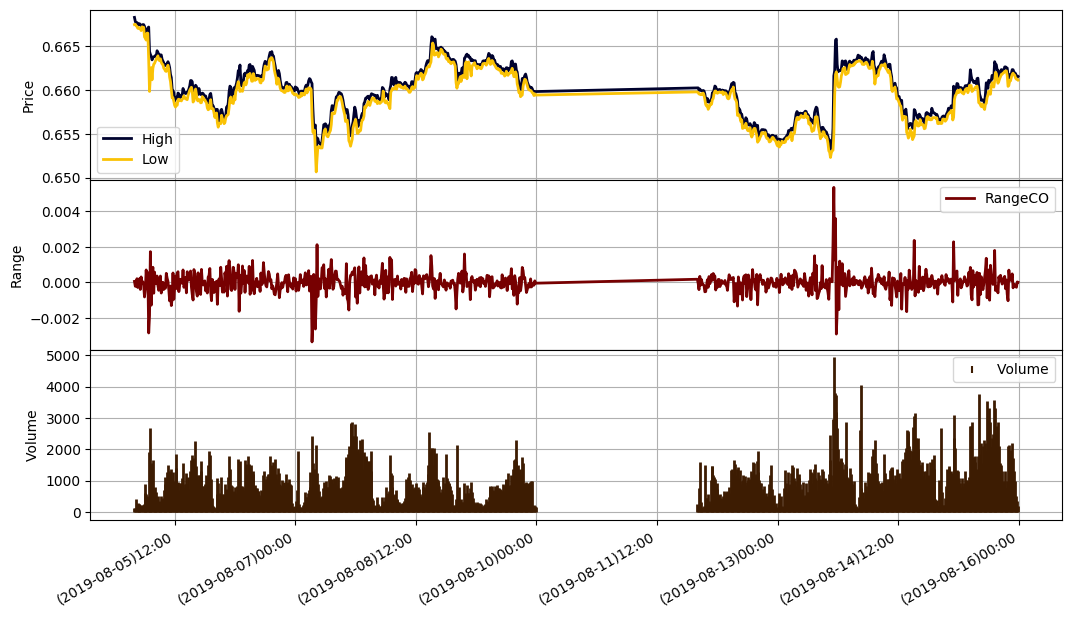

In [19]:
velas.set_time_interval(dt.datetime(2019,8,5),dt.datetime(2019,8,15))

image_name = "Basic_time_series.png"; img_path = folder_images + image_name

gl.init_figure()
n_rows, n_cols = 3,1; size_inches = [12, 6]; 
ax1 = gl.subplot2grid((n_rows,n_cols),(0,0))
ax2 = gl.subplot2grid((n_rows,n_cols),(1,0), sharex = ax1)
ax3 = gl.subplot2grid((n_rows,n_cols),(2,0), sharex = ax1)

velas.plot_series(axes = ax1, series_name = "High")
velas.plot_series(axes = ax1, series_name = "Low", labels = ["","","Price"])
velas.plot_series(axes = ax2, series_name = "RangeCO", labels = ["","","Range"])
velas.plot_series(axes = ax3, series_name = "Volume", labels = ["","","Volume"])

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)
gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)

### Candlesticks and Barcharts

We can plot directly the candlesctick data in the form of barchart or chandlestick chart.

0.01041666662786156


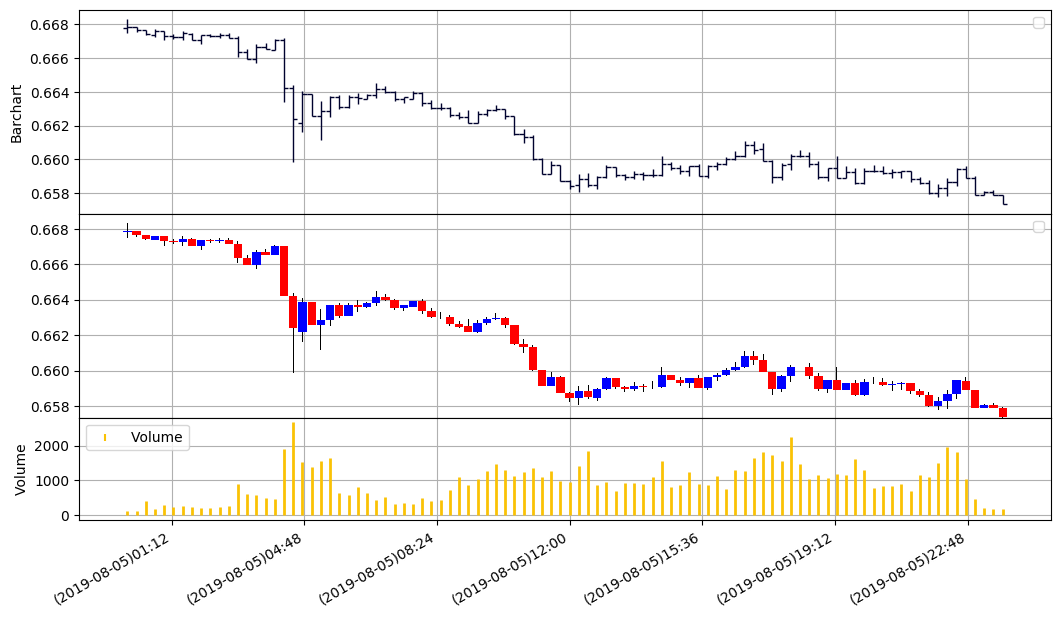

In [20]:
velas.set_time_interval(dt.datetime(2019,8,5),dt.datetime(2019,8,5))

image_name = "Candlesticks_barchart.png"; img_path = folder_images + image_name

gl.init_figure()
n_rows, n_cols = 5,1; size_inches = [12, 6]

ax1 = gl.subplot2grid((n_rows,n_cols),(0,0), rowspan =2)
ax2 = gl.subplot2grid((n_rows,n_cols),(2,0), rowspan =2, sharex = ax1)
ax3 = gl.subplot2grid((n_rows,n_cols),(4,0), sharex = ax1)

velas.plot_barchart(axes = ax1, labels = ["","","Barchart"])
velas.plot_candlesticks(axes = ax2, labels = ["","","Candlesticks"])
velas.plot_series(axes = ax3, series_name = "Volume", labels = ["","","Volume"])

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)
gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)

### Indicators

We can easily plot many of the indicators using the method *plot_indicator()*. Within the library we can write code to perform a different plot per indicator.

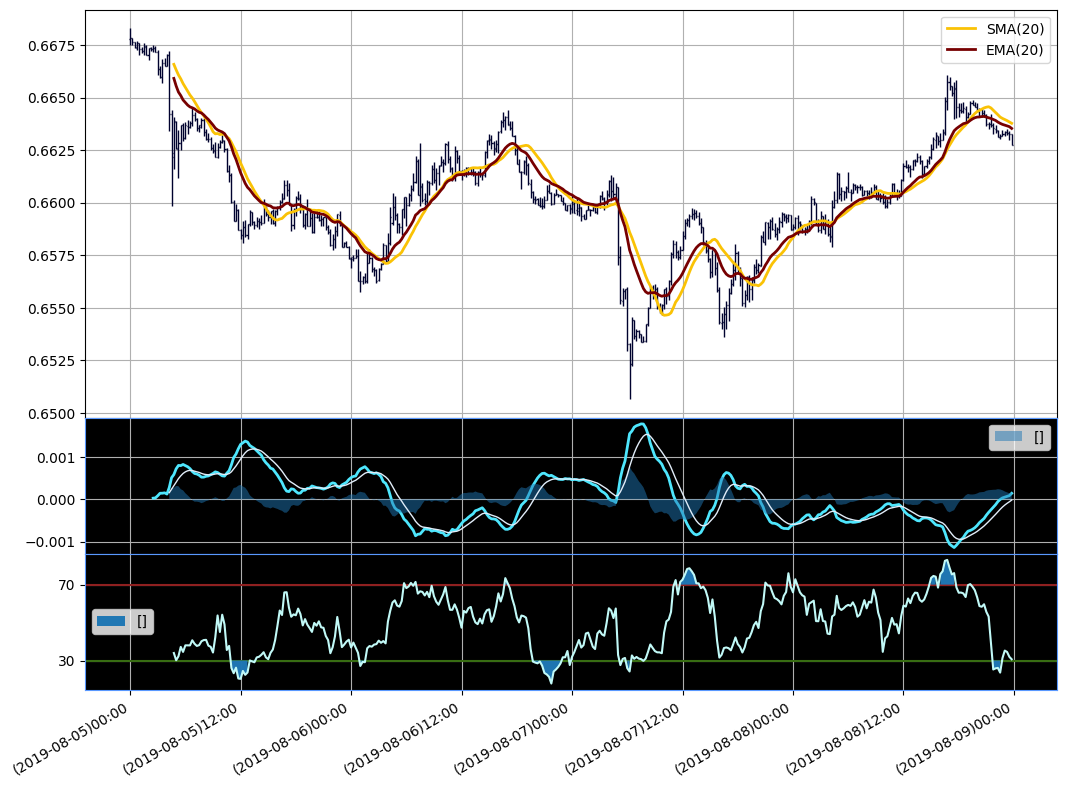

In [21]:
velas.set_time_interval(dt.datetime(2019,8,5),dt.datetime(2019,8,8))

image_name = "Indicators.png"; img_path = folder_images + image_name

gl.init_figure()
n_rows, n_cols = 5,1; size_inches = [12, 8]

ax1 = gl.subplot2grid((n_rows,n_cols),(0,0), rowspan =3)
ax2 = gl.subplot2grid((n_rows,n_cols),(3,0), rowspan =1, sharex = ax1)
ax3 = gl.subplot2grid((n_rows,n_cols),(4,0), sharex = ax1)

velas.plot_barchart(axes = ax1)
velas.plot_indicator(axes = ax1, indicator_name = "SMA")
velas.plot_indicator(axes = ax1, indicator_name = "EMA")

velas.plot_indicator(axes = ax2, indicator_name = "MACD")
velas.plot_indicator(axes = ax3, indicator_name = "RSI")

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)
gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)

## Intraday data manipulation

Usually, when we have intraday data (M1, M5, M15...) we would like to make specific processing to each indpendent trading session. It is usually not a good idea to compute indicators at intraday candlestic level (i.e. an MA over the M5 candlesticks). This is due to the gaps between sessions and different states of the session (busy at opening, calm at lunch time).

We can use the MarketHours class to help us.

In [22]:
timestamps = velas.timestamps
market_hours = MarketHours()

special_trading_days_dict = market_hours.estimate_special_trading_days_from_timestamps(timestamps)
days_dict = MarketHours.get_index_by_days_dict(timestamps)

In [23]:
dates = list(days_dict.keys())
days_dict[dates[0]]

DatetimeIndex(['2019-08-05 00:00:00', '2019-08-05 00:15:00',
               '2019-08-05 00:30:00', '2019-08-05 00:45:00',
               '2019-08-05 01:00:00', '2019-08-05 01:15:00',
               '2019-08-05 01:30:00', '2019-08-05 01:45:00',
               '2019-08-05 02:00:00', '2019-08-05 02:15:00',
               '2019-08-05 02:30:00', '2019-08-05 02:45:00',
               '2019-08-05 03:00:00', '2019-08-05 03:15:00',
               '2019-08-05 03:30:00', '2019-08-05 03:45:00',
               '2019-08-05 04:00:00', '2019-08-05 04:15:00',
               '2019-08-05 04:30:00', '2019-08-05 04:45:00',
               '2019-08-05 05:00:00', '2019-08-05 05:15:00',
               '2019-08-05 05:30:00', '2019-08-05 05:45:00',
               '2019-08-05 06:00:00', '2019-08-05 06:15:00',
               '2019-08-05 06:30:00', '2019-08-05 06:45:00',
               '2019-08-05 07:00:00', '2019-08-05 07:15:00',
               '2019-08-05 07:30:00', '2019-08-05 07:45:00',
               '2019-08-

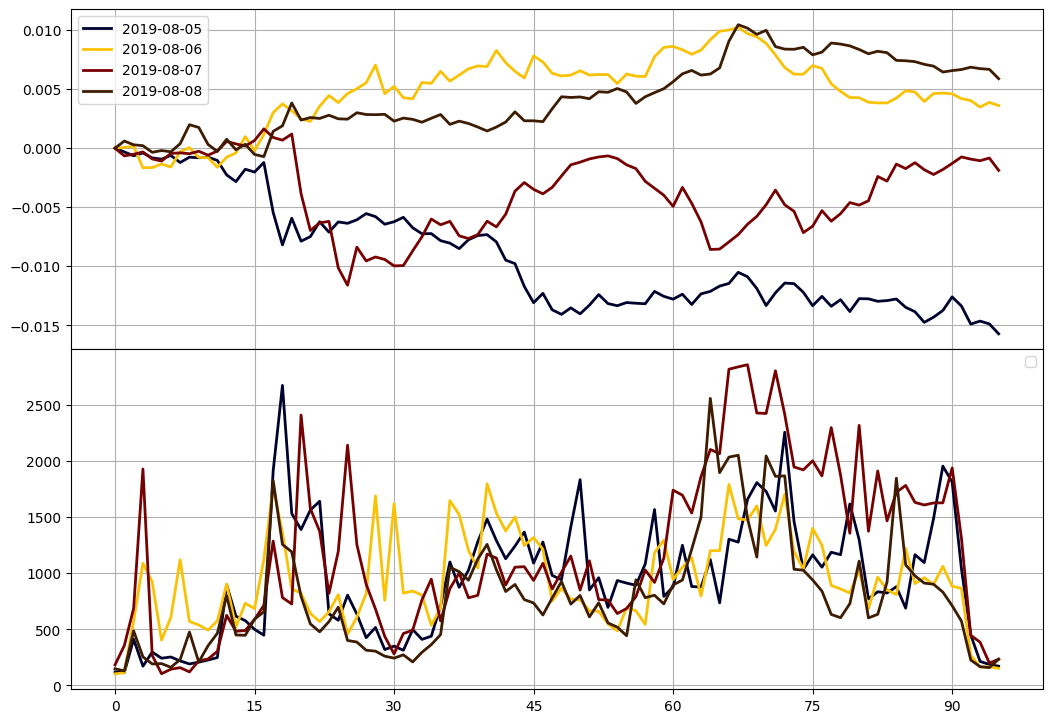

In [24]:
def change_date(date):
    date.__setattr__("year",0); date.month = 0; date.day = 0

image_name = "Intraday.png"; img_path = folder_images + image_name

gl.init_figure()
n_rows, n_cols = 2,1; size_inches = [12, 8]

ax1 = gl.subplot2grid((n_rows,n_cols),(0,0))
ax2 = gl.subplot2grid((n_rows,n_cols),(1,0), sharex = ax1)

for date in days_dict.keys():
    timestamps_date = days_dict[date]
    ## TODO: It is maybe easier to have the time as datetime with no Year,Month,Day
    # times_date = timestamps_date.map(change_date) #pd.Timestamp.time
    
    velas.set_time_interval(date,date)
    close_date = velas["Close"]
    close_date = (close_date - close_date[0])/close_date[0]
    
    volume_date = velas["Volume"]
    
    color = gl.get_color()
    gl.plot(range(close_date.size), close_date, axes = ax1, color = color, legend = [str(date)])
    gl.plot(range(volume_date.size), volume_date, axes = ax2, color = color)
    
gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)
gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)

## Advanced data handling

During the execution of the trading strategies, we want to optimize the recomputation of the series required by the strategies when new candlesticks are available. A set of functionalities to fetch, add and include candlesticks have been created.

In [25]:
candlestick_timestamp = velas.timestamps[20]
candlestick = velas.get_candlestick(candlestick_timestamp)
print(candlestick); print(type(candlestick)); print(candlestick.index)

                        Open     High      Low    Close  Volume
Timestamp                                                      
2019-08-08 05:00:00  0.66138  0.66142  0.66018  0.66043   794.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex(['2019-08-08 05:00:00'], dtype='datetime64[ns]', name='Timestamp', freq=None)


Example when the time provided does not have an exact timestamp

In [26]:
candlestick_timestamp = velas.timestamps[20] + dt.timedelta(minutes = 40)
candlestick = velas.get_candlestick(candlestick_timestamp)

print(candlestick); print(type(candlestick)); print(candlestick.index)

                        Open     High      Low    Close  Volume
Timestamp                                                      
2019-08-08 05:30:00  0.66057  0.66057  0.66015  0.66052   478.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex(['2019-08-08 05:30:00'], dtype='datetime64[ns]', name='Timestamp', freq=None)


In [37]:
gif_name = "first_gif.gif"; gif_path = folder_images + gif_name

velas.set_time_interval(dt.datetime(2019,2,5),dt.datetime(2019,2,27))

n_frames = 10
velas.set_time_interval(start_time = velas.start_time, end_time = velas.end_time + dt.timedelta(days = n_frames))
Y = velas["Close"]
velas.set_time_interval(dt.datetime(2019,2,5),dt.datetime(2019,2,27))
import matplotlib.pyplot as plt

def plot_example(i):
    velas.set_time_interval(start_time = velas.start_time + dt.timedelta(days = 1), end_time = velas.end_time + dt.timedelta(days = 1))
    
    gl.init_figure(figsize=(10,5))
    fig = gl.figure
    #fig, axes = plt.subplots(figsize=(10,5))
    
    axes = None
    if (velas.df.shape[0] > 0):
        velas.plot_barchart(axes = axes)
        velas._df["Close"]
        gl.set_zoom(axes = axes, ypadding = [0.1, 0.1], Y = Y)
    
    plt.close("all")
    return fig

gl.make_gif(plot_example,gif_path, n_frames = n_frames, fps = 10, figsize = [12,5])

 Creating image 10/10

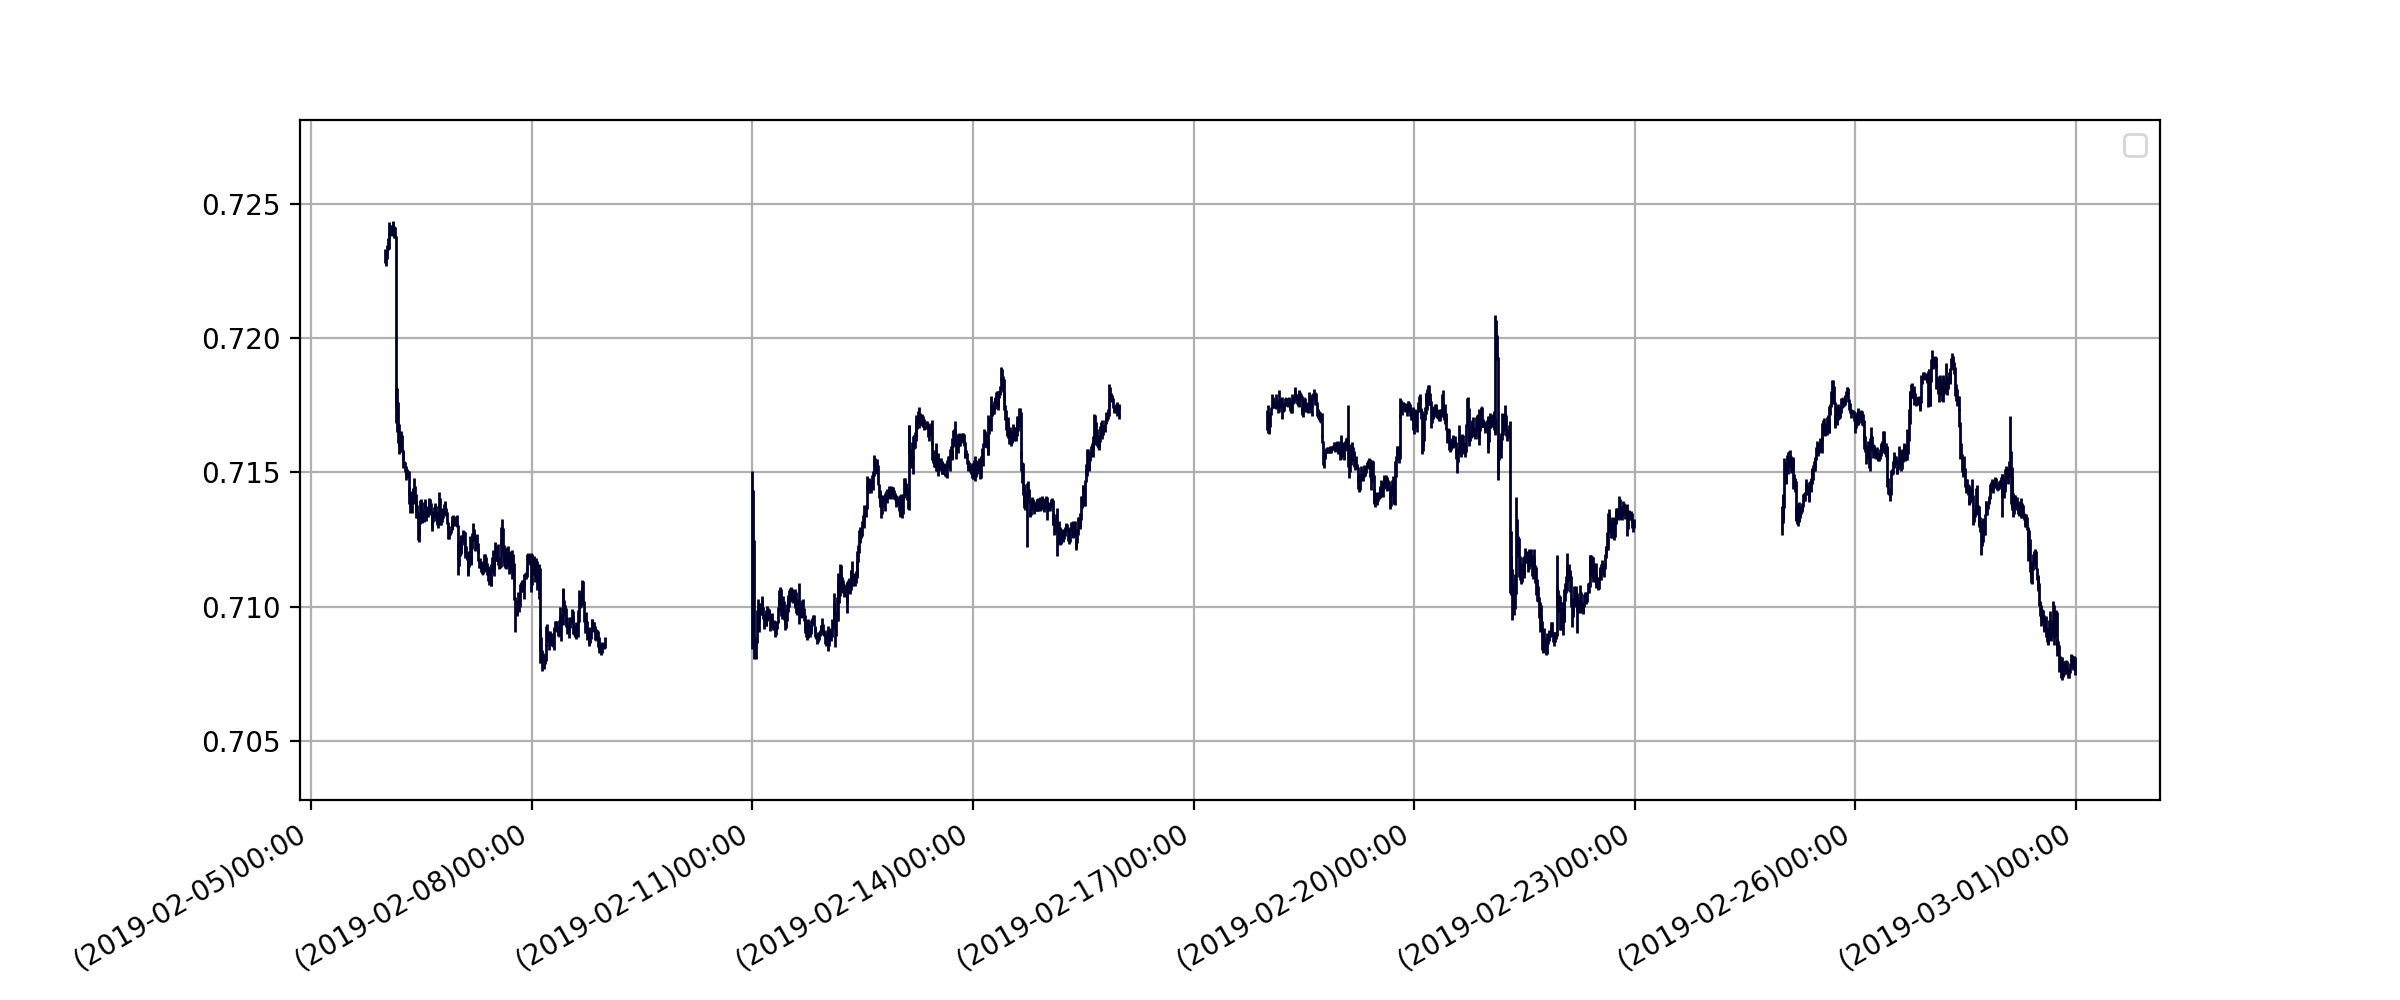

In [38]:
# HTML('<img src="' + gif_path +'">')
Image(gif_path)

In [34]:
video_name = "first_video.avi"; video_path = folder_images + video_name

velas.set_time_interval(dt.datetime(2019,2,5),dt.datetime(2019,2,27))

gl.make_video(plot_example,video_path, n_frames = 5, fps = 5)

 Creating image 5/5

In [30]:
Video(video_path)

In [31]:
HTML("""
    <video alt="test" controls>
        <source src="%s" type="video/avi">
    </video>
"""%(video_path))